# Tutorial 1: Entanglement Forged VQE for the $H_2$ molecule

In this tutorial, we apply Entanglement Forged VQE to compute the energy of a $H_2$ molecule. 

For comparison, you may wish to review how regular VQE is used to solve the same problem [here](https://github.com/Qiskit/qiskit-nature/blob/stable/0.1/docs/tutorials/03_ground_state_solvers.ipynb). 

### Importing the relevant modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from matplotlib import pyplot as plt
import numpy as np

from qiskit.circuit.library import TwoLocal
from qiskit_nature.drivers import PySCFDriver, Molecule
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter

import sys
sys.path.append('../../')
from entanglement_forging import EntanglementForgedGroundStateSolver
from entanglement_forging import EntanglementForgedConfig

## Setting up the problem (the chemistry)

We start by setting up the chemical problem. 

In [3]:
molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)
driver = PySCFDriver(molecule = molecule, basis='sto3g')
problem = ElectronicStructureProblem(driver)

converter = QubitConverter(JordanWignerMapper())

### Classical Result
For comparison, we also compute the classical result. 

In [4]:
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver, NumPyMinimumEigensolverFactory

solver = GroundStateEigensolver(converter, NumPyMinimumEigensolverFactory(use_default_filter_criterion=False))

result = solver.solve(problem)

print('Classical energy = ', result.total_energies[0])

Classical energy =  -1.1373060357534017


## Preparing the bitstrings and the ansatz

The ansatz for Forged VQE consists of a set of input bitstrings and a parameterized circuit. In the current implementation, the bitstrings and parameterized circuit are the same for the alpha particle subspace and the beta particle subspace. For a discussion on picking the bitstrings and designing the ansatz, refer to the Explanatory Material. 

In [5]:
bitstrings = [[1,0],[0,1]]

ansatz = TwoLocal(2, [], 'cry', [[0,1],[1,0]], reps=1)

ansatz.draw()

┌──────────┐
q_0: ─────■──────┤ RY(θ[1]) ├
     ┌────┴─────┐└────┬─────┘
q_1: ┤ RY(θ[0]) ├─────■──────
     └──────────┘

## Running the Forged VQE algorithm

### Statevector simulator

We first create an object that contains all the configuration settings, such as the backend, as well as other execution settings.

In [6]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

config = EntanglementForgedConfig(backend=backend, maxiter = 200, initial_params=[0,0.5*np.pi])

We are now ready to run the calculation and print the results.

In [7]:
calc = EntanglementForgedGroundStateSolver(converter, ansatz, bitstrings, config)
res = calc.solve(problem)

res

Ground state energy (Hartree): -1.1372604047327592
Schmidt values: [-0.99377311  0.11142266]
Optimizer parameters: [  6.2830331  -18.77969966]

We can also extract the results at each iteration of the classical optimizer.  

Energies (from only one paramset in each iteration):


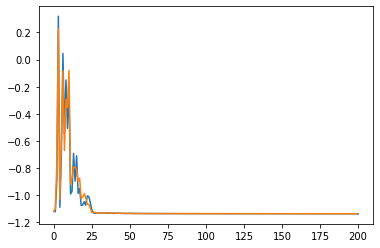

Schmidts (from only one paramset in each iteration):


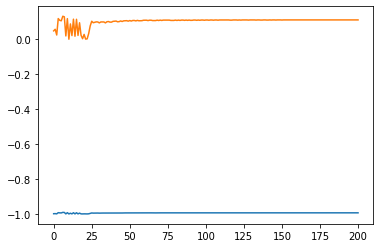

Parameters (from only one paramset in each iteration):


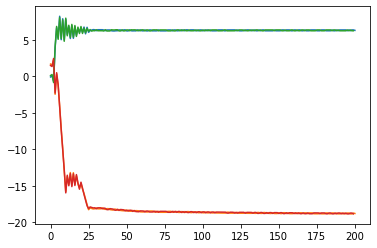

In [8]:
print('Energies (from only one paramset in each iteration):')
plt.plot([e[0] for e in res.get_energies_history()])
plt.plot([e[1] for e in res.get_energies_history()[0:-1]])
plt.show()
print('Schmidts (from only one paramset in each iteration):')
plt.plot([s[0] for s in res.get_schmidts_history()])
plt.show()
print('Parameters (from only one paramset in each iteration):')
plt.plot([p[0] for p in res.get_parameters_history()])
plt.plot([p[1] for p in res.get_parameters_history()[0:-1]])
plt.show()